# Logo Recognition Algorithm with Flickr Logos Training Data

We chose to use data copied from: http://www.image.ntua.gr/iva/datasets/flickr_logos/

The Flickr Logos 27 dataset is an annotated logo dataset downloaded from Flickr and contains more than four thousand classes in total. It consists of **three image collections/sets**.

+ **The training set** contains **810 annotated images**, corresponding to **27 logo classes/brands (30 images for each class)**. All images are annotated with bounding boxes of the logo instances in the image. We allow multiple logo instances per class image. The training set is randomly split in six subsets, each one containing five images per class.

+ **The distractor set contains 4207 logo images/classes**, that depict, in most cases, clean logos. All images come from the Flickr group Identity + Logo Design. Each one of the distractor set images defines its own logo class and we regard the whole image as bounding box.

+ Finally, **the query set consists of 270 images**. There are five images for each of the 27 annotated classes, summing up to 135 images that contain logos. Furthermore, the query set contains 135 Flickr images that do not depict any logo class, giving 270 test images in total.

The brands included in the dataset are: Adidas, Apple, BMW, Citroen, Coca Cola, DHL, Fedex, Ferrari, Ford, Google, Heineken, HP, McDonalds, Mini, Nbc, Nike, Pepsi, Porsche, Puma, Red Bull, Sprite, Starbucks, Intel, Texaco, Unisef, Vodafone and Yahoo.

## Ideas for further developing project

+ Idea for title "Examining the impact of various preprocessing steps on accuracy of an ML model"

+ Compare the impact of augmentation (and with that also the increase in data) on accuracy of model

+ Compare the improvement of accuracy when keeping color vs grey-scale and evaluate the tradeoff in terms of computing capacity

+ Compare the improvement of accuracy for different dimension sizes --> trade-off, a certain specificity is needed to find the uniqueness of the logo, but too many dimensions can lead to poorer applicability to different scenarios.


### Step 1: Accessing Raw Images Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras 
import tarfile
import os
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
import requests
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

In [5]:
# """Accessing Data (41.9s)"""

# url = "http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz"
# response = requests.get(url) # Send a get request to the URL
# content = response.content #content in bytes

# #saving the main file to specified directory with name "flickr27.tar"
# filename = "flickr27.tar"
# macbookuser = input("I am a macbook user (yes/no): ")
# if macbookuser == "yes":
#     specified_directory = input("Specify the path to the directory for which you want to store file (make sure to add / or \ at the end): ") #/Users/veronicalarsson/Downloads/
#     image_path = "flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz"
#     directory_separator = '/'
# else:
#     specified_direcotory = "r" + input("Specify the path to the directory for which you want to store file (make sure to add / or \ at the end): ")
#     image_path = "flickr_logos_27_dataset\flickr_logos_27_dataset_images.tar.gz"
#     directory_separator = '\\'

# with open(specified_directory + filename, "wb") as file: #the file will be opened for writing in binary (b) mode, allowing you to write (w) binary data directly to the file
#     file.write(content) #writing content to the specified filename with associated path


# #to access the files, we need to open the main tar file, we then store the unzipped files in a new directory
# tar_file_path = specified_directory + filename #path to tar.gz file
# unzipped_path = specified_directory + "unzipped" #new path to unzipped content

# with tarfile.open(tar_file_path, 'r:gz') as tar: #Open the tar.gz file and store all content in folder with specified path name
#     tar.extractall(path= unzipped_path) 


# #again we need to open a second tar file within the unzipped tar file for getting the raw images, we then store them in a new directory:
# tar_file_path_2 = unzipped_path + directory_separator + image_path
# unzipped_images_path= specified_directory + "unzipped_images"

# with tarfile.open(tar_file_path_2, 'r:gz') as tar:
#     tar.extractall(directory_separator + unzipped_images_path) #Extract all contents to a newly created directory

In [2]:
# """Getting df with all filenames and images (missing labels at this stage)"""

# # Path to directory containing image files
# image_directory = unzipped_images_path+ directory_separator +'flickr_logos_27_dataset_images' #example: r'C:\Users\EmiliaGachowetz-Gepp\Documents\New ML\images\flickr_logos_27_dataset_images'

# # List of all files (images) in the directory
# image_filenames = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

# # Function to process images and store them in a DataFrame
# def process_images(image_directory, image_filenames):
#     image_data = []  # List to store image data

#     for filename in image_filenames:
#         try:
#             image_path = os.path.join(image_directory, filename)  # Construct the full path to the image file
#             img = Image.open(image_path)  # Open the image using Pillow (PIL)
#             img = img.convert('L') #Converting to gray scale
#             img_resized = img.resize((100, 100), Image.LANCZOS)  # Resize the image to 100x100 pixels
#             # img_array = np.array(img_resized) # Convert image to numpy array if needed
#             image_data.append({'Filename': filename, 'Image': img_resized})

#         except Exception as e:
#             # Handle errors (e.g., if the image cannot be processed)
#             print(f"Error processing image {filename}: {e}")

#     # Convert the list of dictionaries to a DataFrame
#     image_df = pd.DataFrame(image_data)
#     return image_df

# # Call the function to process images and store them in a DataFrame
# image_df = process_images(image_directory, image_filenames)
# image_df.head()


NameError: name 'unzipped_images_path' is not defined

In [ ]:
# Selecting one picture from the DataFrame
some_pic = image_df['Image'].iloc[0]

# Display the image using matplotlib
plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

### Step 2: Saving data and associated labels in images_info:

The data frame is built like this:

+ Image filename (unique ID)

+ Class name (i.e. the label)

+ Training subset of class (1,...,6)

+ Coordinates of the top left and bottom right corners (x1 y1 x2 y2)

(x1 = top left horizontal, y1 = top left vertical, x2 = bottom right horizontal, y2 = bottom right vertical)

In [ ]:
#2. read csv which contains information about images
info =pd.read_csv(unzipped_path + directory_separator + 'flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt', sep='\s+', header=None)

#renaming the columns in images_info:
new_column_names = ['Filename', 'Label', 'Subset', 'x1', 'y1','x2', 'y2']
info.columns=new_column_names
#info.head()

#merging the df with the image_df
image_df = image_df.merge(info, how = 'inner', on = 'Filename')
image_df = image_df[['Filename', 'Image', 'Label']]
image_df

### Step 3: Augmenting the image_df data

Data augmentation is a technique used in machine learning and deep learning to artificially increase the size of a training dataset by applying various transformations to the existing data. The goal is to enhance the model's generalization ability, robustness, and performance by exposing it to a more diverse set of examples during training. This technique is particularly useful when the available dataset is limited.

Common data augmentation techniques include:

1. **Rotation:** Rotating images by a certain degree.
2. **Flip:** Flipping images horizontally or vertically.
3. **Zoom:** Zooming in or out of images.
4. **Translation:** Shifting images horizontally or vertically.
5. **Shear:** Applying a shearing transformation to images.
6. **Brightness and Contrast Adjustment:** Changing the brightness and contrast of images.
7. **Noise Injection:** Adding random noise to images.
8. **Color Jittering:** Adjusting the color values of images.

For example, in image classification tasks, if you have a dataset of cat images, you can apply data augmentation to generate variations of the same images by rotating, flipping, zooming, or changing their colors. This way, the model sees different perspectives of the same data during training, which can help it become more robust to variations and improve its performance on new, unseen data.

In deep learning frameworks and libraries, there are often built-in tools or functions for applying data augmentation during the training process. This allows practitioners to easily incorporate these transformations into their pipelines without manually creating augmented datasets.

In [ ]:
"""Augmenting and scaling all images (25m 12.3s with 270x270) --> (4m 12.6s with 100x100) --> (8m+ with 100x100 RGB)"""
transform = transforms.ToTensor()

def augment_images(images_df):
    '''This function crops, rotates, and scales images and saves them in the specified output folder'''
    dataframes = []  # List to store DataFrames
    scaler = MinMaxScaler()

    for index, row in images_df.iterrows(): # Loop through each row in the augmented DataFrame
        filename = row['Filename']
        #x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

        # Find the original image from the images DataFrame
        original_image_row = images_df[images_df['Filename'] == filename].iloc[0]
        original_image = original_image_row['Image']

        # Rotate, scale, and crop the image
        operations = ['original', 'rotated', 'scaled', 'top-bottom flipped']
        images = [original_image, 
                  original_image.rotate(45), 
                  original_image.resize((int(original_image.width * 1.5), int(original_image.height * 1.5))), 
                  original_image.transpose(Image.FLIP_TOP_BOTTOM)
                  ]

        for i in range(len(operations)):
            op = operations[i]
            img = images[i]
            img = img.resize((100, 100), Image.LANCZOS)
            img_array = np.array(img).flatten() # Flatten the pixel array
            img_scaled = scaler.fit_transform(img_array.reshape(-1, 1)).flatten # Scale pixel values to range [0, 1]
            data = {'Filename': [filename], 'Operation': [op]}
            data['Pixels'] = img_scaled
            for j in range(len(img_array)):
                data[f'Pixel_{j}'] = [img_array[j]] # Create a separate column for each scaled pixel
            df = pd.DataFrame(data)
            dataframes.append(df)

    # Concatenate all DataFrames in the list
    modified_df = pd.concat(dataframes, ignore_index=True)
    return modified_df

# Storing the augmented df
labelled_augmented_df = augment_images(image_df)
labelled_augmented_df = pd.merge(labelled_augmented_df, images_info, on='Filename', how='inner')
labelled_augmented_df.head(10)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding label
label_encoder = LabelEncoder()
labelled_augmented_df['Label_Encoded'] = label_encoder.fit_transform(labelled_augmented_df['Label'])

# Dropping unnecessary columns from the merged DataFrame
training_df = labelled_augmented_df.drop(columns=['Filename', 'Operation', 'Subset', 'x1', 'y1', 'x2', 'y2'])

print("Merged DataFrame with encoded labels:")
training_df.head()

In [ ]:
"""Saving scaled (0-1) training data (22m 22.5s with 270x270 data) (1m 56.7s with 100x100)"""
#training_df.to_csv(specified_directory + 'model_data.csv', index = False) --> name for 270, 270 pixels data (51529 features)
#training_df.to_csv(specified_directory + 'model_data_100x100.csv', index = False) #--> name for 100,100 pixels data

### Loading New Dataset (Step 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras 
import tarfile
import os
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
import requests
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

In [2]:
"""Getting df with all filenames and images (missing labels at this stage)"""
# (150,150) grayscale --> 2m 28.9s
# (150,150) rgb, with pixels as cols --> 

def load_images_from_folder(folder_path, image_size=(150, 150)):
    images = []
    
    # Recursively traverse through the folder structure
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, filename)
            
            # Check if the file is an image
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                # Load the image using PIL (Python Imaging Library)
                try:
                    with Image.open(file_path) as img:
                        img = img.resize(image_size) #resizing image
                        #img = img.convert('L') #Converting to gray scale
                        img_array = np.array(img) / 255.0 # Convert the image to numpy array and normalize pixel values
                        images.append({'Filename': filename, 'Image': img_array}) # Append the image array to the list
                except Exception as e:
                    print(f"Error loading image '{file_path}': {e}")
    
    # Convert the list of dictionaries to a DataFrame
    images_df = pd.DataFrame(images)
    return images_df

# Loading
folder_path = '/Users/veronicalarsson/Downloads/datasetcopy/trainandtest/train'
image_df = load_images_from_folder(folder_path)
print('Image Dataframe: \n \n', image_df.head())

: 

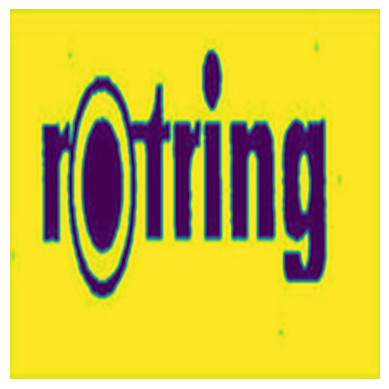

In [3]:
# Selecting one picture from the DataFrame
some_pic = image_df['Image'].iloc[0]

# Display the image using matplotlib
plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

In [22]:
"""Augmenting and scaling all images ( with 150x150, gray) --> kernel crashed"""

def augment_images(images_df):
    '''This function crops, rotates, and scales images and saves them in the specified output folder'''
    dataframes = []  # List to store DataFrames
    scaler = MinMaxScaler()

    for index, row in images_df.iterrows(): # Loop through each row in the augmented DataFrame
        filename = row['Filename']

        # Find the original image from the images DataFrame
        original_image_row = images_df[images_df['Filename'] == filename].iloc[0]
        original_image = original_image_row['Image']

        # Rotate, scale, and crop the image
        operations = ['original', 'rotated', 'scaled', 'top-bottom flipped']
        images = [original_image, 
                  original_image.rotate(45), 
                  original_image.resize((int(original_image.width * 1.5), int(original_image.height * 1.5))), 
                  original_image.transpose(Image.FLIP_TOP_BOTTOM)
                  ]

        for i in range(len(operations)):
            op = operations[i]
            img = images[i]
            img = img.resize((100, 100), Image.LANCZOS)
            img_array = np.array(img).flatten() # Flatten the pixel array
            img_scaled = scaler.fit_transform(img_array.reshape(-1, 1)).flatten # Scale pixel values to range [0, 1]
            data = {'Filename': [filename], 'Operation': [op]}
            data['Pixels'] = img_scaled
            for j in range(len(img_array)):
                data[f'Pixel_{j}'] = [img_array[j]] # Create a separate column for each scaled pixel
            df = pd.DataFrame(data)
            dataframes.append(df)

    # Concatenate all DataFrames in the list
    modified_df = pd.concat(dataframes, ignore_index=True)
    return modified_df

# Storing the augmented df
labelled_augmented_df = augment_images(image_df)
#labelled_augmented_df = pd.merge(labelled_augmented_df, images_info, on='Filename', how='inner')
print(labelled_augmented_df.head(10))

: 

In [4]:
"""Loading Labels & Merging (37.9s to load)"""

# Loading Labels
label_path = '/Users/veronicalarsson/Downloads/datasetcopy/List/train_images.txt'
labeltranslator = pd.read_csv(label_path, sep = '/', header = None, names = ['Label','Filename'])
print('Label-Translator Dataframe: \n \n', labeltranslator.head())

# Merging 
merged_df = image_df.merge(right = labeltranslator, how = 'inner', on = 'Filename')
print('Merged Dataframe: \n \n', merged_df.head())

Label-Translator Dataframe: 
 
      Label Filename
0  24seven    1.jpg
1  24seven   10.jpg
2  24seven   11.jpg
3  24seven   14.jpg
4  24seven   16.jpg


KeyboardInterrupt: 

### Step 4: Testing Keras Model

In [ ]:
from sklearn.model_selection import train_test_split

#In order to store the data as detailed as possible, we use the data split up into features and labels.
model_data = merged_df
#model_data = pd.read_csv('/Users/veronicalarsson/Downloads/model_data.csv') #8m 59.6s

In [ ]:
# Split the DataFrame into features (pixels) and labels
features = model_data.drop(columns=['Label_Encoded', 'Label', 'Image']).values  # Flattened and scaled features (pixel values)
labels = model_data['Label_Encoded'].values  # Labels

# Reshape the flattened feature data into images (assuming each image is 227x227 pixels)
#image_shape = (227, 227)
#features = features.reshape(-1, *image_shape, 1)  # Reshape flattened features into images and add 1 channel for grayscale images

In [ ]:
"""Creates training and test sets (2m 29.9s)"""
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Display the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Building subsets for testing
# X_train = X_train[:100]
# y_train = y_train[:100]
# X_test = X_test[:100]
# y_test = y_test[:100]

# # Display the shapes of the resulting splits
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

In [ ]:
"""Model 1"""
#Building model

xshape = X_train.shape
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = xshape), #The 18144 represents the batch size (number of samples), and 10000 represents the number of features for each sample.
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(27)
])

#after the input layer, add the first convolutional layer with 32 2x2-filters 
model_1.add(Conv2D (kernel_size = (2,2), filters = 32, 
                      input_shape=train_tensors.shape[1:], activation='relu'))

#add pooling layer
model_1.add(MaxPooling2D(pool_size=2))

#add the second convolutional layer with 64 2x2-filters 
model_1.add(Conv2D(kernel_size = 2, filters = 64, activation='relu'))
model_1.add(MaxPooling2D(pool_size=2))
#add the third convolutional layer with 128 2x2-filters 
model_1.add(Conv2D(kernel_size = 2, filters = 128, activation='relu'))
#add a dropout layer so that each node has a chance of 20% to be dropped when training
model_1.add(Dropout(0.2))
model_1.add(MaxPooling2D(pool_size = 2))
#add a global average pooling layer
model_1.add(GlobalAveragePooling2D())
#add the final fully connected output layer with 109 node for all 109 logo classes
model_1.add(Dense(109, activation = 'softmax'))

model_1.summary()



In [ ]:
#compiling neural network
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#To start training, call the model.fit method—so called because it "fits" the model to the training data:
model_1.fit(X_train, y_train, epochs=10)

#Next, compare how the model performs on the test dataset:
test_loss, test_acc = model_1.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

#predictions
probability_model = tf.keras.Sequential([model_1, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)
print(predictions[0])
#A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 27 different logos.
#You can see which label has the highest confidence value by calling:
print(f'most probable logo is',np.argmax(predictions[0]))

#the model is most confident that this image is XX
#Examining the test label shows that this classification is correct?False?:

y_test[0]

In [ ]:
"""Model 2"""
model_2 = Sequential()
#model_2.add(keras.layers.Flatten(input_shape=100,100))
model_2.add(keras.layers.Dense(10, activation='relu'))
model_2.add(keras.layers.Dropout(0.2))
model_2.add(keras.layers.Dense(27))

model_2.summary()
            
predictions = model_2(X_train[:1]).numpy()
predictions

#Using `tf.nn.softmax` function converts these logits to *probabilities* for each class: 
tf.nn.softmax(predictions).numpy()

#Defining a loss function for training using `losses.SparseCategoricalCrossentropy`:
#This loss is equal to the negative log probability of the true class: 
#The loss is zero if the model is sure of the correct class.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train[:1], predictions).numpy()

#Before training, configuring and compiling the model
#Setting the optimizer class to adam, the loss to the loss_fn function defined earlier

model_2.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

#or as before but with sgd: model_2.compile(loss="sparse_categorical_crossentropy",
             #optimizer="sgd",
            # metrics=["accuracy"]) we use sparse... bc sparse labels and classes are exclusive

#training and evaluation
history=model_2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

#or Model.evaluate` method checks the model's performance, usually on a validation set and test set
#model_2.evaluate(x_test,  y_test, verbose=2)

#model to return a probability, you can wrap the trained model, and attach the softmax to it:
probability_model = tf.keras.Sequential([model_2, tf.keras.layers.Softmax()])
probability_model(X_test[:5])
